In [1]:
# Created January 7, 2022
# Updated January 7, 2022
import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
# mpl formatting
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl_configs)
import methods.ax_methods as ax_methods
import numpy as np; rnd = np.random.default_rng()

import pickle


In [58]:
import methods.filter_lineages as fl

def find_large_freqs(bac, mouse, day, cutoff=1e-2, min_init_freq=0):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    day0_freqs = read_array[0] / read_array[0].sum()

    if min_init_freq:
        day0_valid = day0_freqs > min_init_freq

    mouse_reads = read_array[ row_ids[(mouse, day)] ]
    mouse_freqs = mouse_reads / mouse_reads.sum()
    large_indices = np.where((mouse_freqs >= cutoff)*(mouse_freqs > day0_freqs)*day0_valid)[0]

    large_freqs = mouse_freqs[large_indices]

    return large_freqs, large_indices

def find_largest_freqs_across_mice(bac, mice, day, indices):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    mice_reads = read_array[ [ row_ids[(mouse, day)] for mouse in mice ] ]
    mice_freqs = np.einsum('ij, i->ij', mice_reads, mice_reads.sum(axis=1)**-1.)[:, indices]
    largest_freqs_across_mice = np.max( mice_freqs, axis=0 )
    large_mouse_indices = np.argmax( mice_freqs, axis=0)

    return largest_freqs_across_mice, large_mouse_indices

def plot_large_barcode_fc_vs_largest(ax, bac, focal_mouse, comparison_mice, day,
                                     cutoff=1e-2, min_init_freq=0,  plot=True):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    # find large lineages in one mouse
    large_freqs, large_indices = find_large_freqs(bac, focal_mouse, day,
                                                  cutoff=cutoff, min_init_freq=min_init_freq)

    # what are these lineages doing in other mice
    largest_freqs_comparison_mice, large_mouse_indices = find_largest_freqs_across_mice(bac, comparison_mice, day, large_indices)
    day0_freqs = read_array[0] / read_array[0].sum()

    greater_one = large_freqs/largest_freqs_comparison_mice > 1
    if plot:
        ax.scatter( (large_freqs/day0_freqs)[greater_one], (large_freqs/largest_freqs_comparison_mice)[greater_one], color='green', s=3)
        ax.set_yscale('log')
        ax.set_xscale('log')

    return (large_freqs/largest_freqs_comparison_mice)[greater_one], large_indices

def plot_large_barcode_fc_vs_median(ax, bac, focal_mouse, comparison_mice, day,
                                    cutoff=1e-2, min_init_freq=0):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    # find large lineages in one mouse
    large_freqs, large_indices = find_large_freqs(bac, focal_mouse, day,
                                                  cutoff=cutoff, min_init_freq=min_init_freq)

    # what are these lineages doing in other mice
    largest_freqs_comparison_mice = find_median_freqs_across_mice(bac, comparison_mice, day, large_indices)
    day0_freqs = read_array[0] / read_array[0].sum()

    ax.scatter( large_freqs/day0_freqs, large_freqs/largest_freqs_comparison_mice)
    ax.set_yscale('log')
    ax.set_xscale('log')

def find_ratio_first_second_largest_across_mice(bac, mice, day):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    mice_reads = read_array[ [row_ids[(mouse, day)] for mouse in mice] ]
    freqs = np.einsum('ij, i->ij', mice_reads, mice_reads.sum(axis=1)**-1.)

    greater_zero = ((freqs > 0).sum(axis=0) > 1)
    freqs = np.ma.masked_array(freqs, np.tile(~greater_zero, (freqs.shape[0], 1)))

    ratios = []
    for i in range(freqs.shape[-1]):
        if freqs.mask[0, i] == True:
            ratios.append(np.nan)
            continue
        lineage_freqs = freqs[:, i][np.argsort(freqs[:, i])]
        ratios.append( lineage_freqs[-1]/lineage_freqs[-2] )
    return ratios


/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_26788/719357453.py:46: RuntimeWarning: divide by zero encountered in true_divide
  greater_one = large_freqs/largest_freqs_comparison_mice > 1
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_26788/719357453.py:52: RuntimeWarning: divide by zero encountered in true_divide
  return (large_freqs/largest_freqs_comparison_mice)[greater_one], large_indices
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_26788/719357453.py:46: RuntimeWarning: divide by zero encountered in true_divide
  greater_one = large_freqs/largest_freqs_comparison_mice > 1
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_26788/719357453.py:52: RuntimeWarning: divide by zero encountered in true_divide
  return (large_freqs/largest_freqs_comparison_mice)[greater_one], large_indices
/var/folders/x3/8f6xdlhn4hscmskkzs52dycc0000gn/T/ipykernel_26788/719357453.py:46: RuntimeWarning: divide by zero encountered in true_divide
  greater_one 

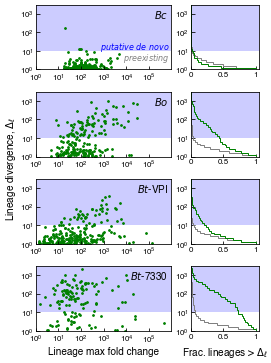

In [66]:
diet = 'HF'
mice = diet_mice_map[diet]
min_init_freq = 1e-6
cutoff = 1e-3
day = 16

fig = plt.figure(figsize=(4, 6))
outer = mpl.gridspec.GridSpec(nrows=7, ncols=2, height_ratios=[1, 0.1, 1, 0.1, 1, 0.1, 1], width_ratios=[1, 0.5], figure=fig)

if 'outer ax format':
    outer_ax = fig.add_subplot(outer[:, 0])
    outer_ax.set_xlabel('Lineage max fold change', fontsize=10, labelpad=15)
    outer_ax.set_ylabel(r'Lineage divergence, $\Delta_\ell$', labelpad=18, fontsize=10)
    outer_ax.set_xticks([])
    outer_ax.set_yticks([])
    ax_methods.turn_off_ax(outer_ax)

    survival_ax = fig.add_subplot(outer[:, 1])
    survival_ax.set_xlabel(r'Frac. lineages > $\Delta_\ell$', fontsize=10, labelpad=7.5)
    ax_methods.turn_off_ax(survival_ax)

bac_large_divergence_indices = {bac:[] for bac in bacteria}

for b, bac in enumerate(bacteria):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    day0_freqs = read_array[0] / read_array[0].sum()

    ax = fig.add_subplot(outer[2*b, 0])
    ax.axhline(1, color='black', linestyle='dashed', zorder=1)

    all_focal_ratios = []
    all_large_indices = set()
    for f, focal_mouse in enumerate(mice):
        comparison_mice = mice[:f] + mice[f+1:]
        ratios, large_indices = plot_large_barcode_fc_vs_largest(ax, bac, focal_mouse, comparison_mice, day,
                                         cutoff=cutoff, min_init_freq=min_init_freq, plot=False)

        all_focal_ratios.extend(ratios)
        all_large_indices.update(large_indices)

    reads10 = read_array[ [row_ids[(mouse, 10)] for mouse in mice] ]
    freqs10 = np.einsum('ij, i->ij', reads10, reads10.sum(axis=1)**-1.)
    reads16 = read_array[ [row_ids[(mouse, 16)] for mouse in mice] ]
    freqs16 = np.einsum('ij, i->ij', reads16, reads16.sum(axis=1)**-1.)

    large = ((freqs16 > 1e-3)).sum(axis=0) > 0
    # large = ((freqs10 > 1e-3) + (freqs16 > 1e-3)).sum(axis=0) > 0
    all_large_indices = np.arange(large.shape[-1])[large]

    ratios16 = find_ratio_first_second_largest_across_mice(bac, mice, 16)
    ratios10 = find_ratio_first_second_largest_across_mice(bac, mice, 10)
    focal_ratios16 = np.array(ratios16)[list(all_large_indices)]
    focal_ratios10 = np.array(ratios10)[list(all_large_indices)]


    focal_freqs0 = read_array[0][list(all_large_indices)] / read_array[0].sum()

    max_focal_freqs10 = np.max( freqs10[:, list(all_large_indices)], axis=0)
    max_focal_freqs16 = np.max( freqs16[:, list(all_large_indices)], axis=0)


    # ax.scatter( max_focal_freqs10/focal_freqs0, max_focal_freqs16/max_focal_freqs10)
    bac_large_divergence_indices[bac] = all_large_indices[focal_ratios16 > 10]
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1, 9*10**5)
    ax.set_xticks([1,10,10**2,10**3,10**4,10**5])
    ax.set_yticks([1,10,10**2, 10**3])
    ax.tick_params(axis='both', labelsize=8)
    ax.scatter(max_focal_freqs16/focal_freqs0, focal_ratios16, s=3, color='green')
    ax.text(0.98, 0.8, BAC_FORMAL_NAMES[bac],
            transform=ax.transAxes, fontsize=10, horizontalalignment='right')
    ax.set_ylim(1, 3*10**3)
    ylim = ax.get_ylim()
    ax.axhspan(10, ax.get_ylim()[1], color='blue', alpha=0.2, zorder=0, linewidth=0)
    if bac == 'BWH2':
        ax.text(0.99, 0.32, '$putative~\\it{de~novo}$', color='blue',
                transform=ax.transAxes, horizontalalignment='right', fontsize=8)
        ax.text(0.99, 0.15, '$preexisting$', color='grey',
                transform=ax.transAxes, horizontalalignment='right', fontsize=8)


    ax = fig.add_subplot(outer[2*b, 1])
    ax.set_yscale('log')
    ax.set_yticks([1,10,10**2, 10**3])
    ax.set_xticks([0, 0.5, 1])
    ax.set_xticklabels(['0', '0.5', '1'])
    ax.tick_params(axis='both', labelsize=8)
    ax.hist(ratios16, bins=np.logspace(0, 4, 41), density=True, color='grey', orientation='horizontal', cumulative=-1, histtype='step')
    ax.hist(focal_ratios16, bins=np.logspace(0, 4, 41), density=True, color='green', orientation='horizontal', cumulative=-1, histtype='step')
    ax.axhspan(10, ax.get_ylim()[1], color='blue', alpha=0.2, zorder=0, linewidth=0)
    ax.set_ylim(ylim)
#
fig.savefig(f'{biorxiv}/SI_denovo_mutations.pdf')

[[[30588132. 30588132. 30588132. 30588132. 30588132.]
  [30588132. 30588132. 30588132. 30588132. 30588132.]
  [30588132. 30588132. 30588132. 30588132. 30588132.]
  [30588132. 30588132. 30588132. 30588132. 30588132.]
  [30588132. 30588132. 30588132. 30588132. 30588132.]]

 [[  566304.   527274.   380348.   476690.   358950.]
  [  566304.   527274.   380348.   476690.   358950.]
  [  566304.   527274.   380348.   476690.   358950.]
  [  566304.   527274.   380348.   476690.   358950.]
  [  566304.   527274.   380348.   476690.   358950.]]

 [[  141111.   514895.   304091.   781236.   678502.]
  [  141111.   514895.   304091.   781236.   678502.]
  [  141111.   514895.   304091.   781236.   678502.]
  [  141111.   514895.   304091.   781236.   678502.]
  [  141111.   514895.   304091.   781236.   678502.]]

 [[  852591.   728665.   818277.   743710.   716655.]
  [  852591.   728665.   818277.   743710.   716655.]
  [  852591.   728665.   818277.   743710.   716655.]
  [  852591.   728665.

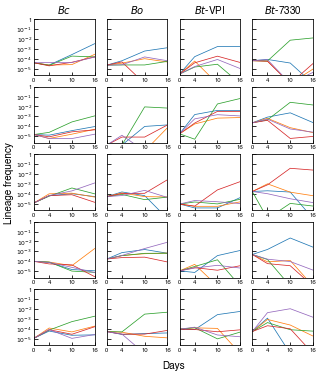

In [86]:
num_examples = 5 # per species

fig = plt.figure(figsize=(5, 6))
outer = mpl.gridspec.GridSpec(nrows=num_examples, ncols=4)


# fig.suptitle(r'Putative $\it{de~novo}$ example trajectories')
ax = fig.add_subplot(outer[:, :])
ax_methods.turn_off_ax(ax)
ax.set_xlabel('Days', fontsize=10, labelpad=8)
ax.set_ylabel('Lineage frequency', fontsize=10, labelpad=10)

mice = [6, 7, 8, 9, 10]


rnd = np.random.default_rng(seed=16)
for b, bac in enumerate(['BWH2', 'Bovatus', 'BtVPI', 'Bt7330']):
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]
    day0_freqs = read_array[0] / read_array[0].sum()

    example_indices = rnd.choice(bac_large_divergence_indices[bac], num_examples, replace=False)
    # example_indices = [1,2,3,4]

    mice_freqs = np.zeros((4, len(mice), num_examples))
    mice_depths = np.zeros((4, len(mice), num_examples))
    mice_freqs[0] = np.tile(day0_freqs[example_indices], (len(mice), 1))
    mice_depths[0] = np.tile(read_array[0].sum(), (len(mice), 1))
    for d, day in enumerate(days):
        reads = read_array[ [row_ids[(mouse, day)] for mouse in mice] ]
        freqs = np.einsum('ij, i->ij', reads, reads.sum(axis=1)**-1.)[:, example_indices]
        mice_freqs[d+1] = freqs
        mice_depths[d+1] = reads.sum(axis=1)

    print(mice_depths)


    for j in range(num_examples):
        ax = fig.add_subplot(outer[j, b])

        example_trajectories = mice_freqs[:, :, j]
        min_freq = np.min(example_trajectories[example_trajectories>0])

        # for m in range(len(mice)):
        #     mouse_trajectory = example_trajectories[:, m]
        #     if mouse_trajectory[1] == 0:
        #         if mouse_trajectory[2:].sum() == 0:
        #             mouse_trajectory[1:] = 10**-7
        #         else:
        #             mouse_trajectory[1] = 10**-7
        #     elif mouse_trajectory[2] == 0:
        #         if mouse_trajectory[3] == 0:
        #             mouse_trajectory[2:] = 10**-7
        #         else:


        where_zero = np.where(example_trajectories == 0)
        for (t, m) in zip(*where_zero):
            if t < 3 and example_trajectories[t-1, m] < 1/mice_depths[t, m, 0] and example_trajectories[t+1,m] > 0:
                    example_trajectories[t,m] = example_trajectories[t-1,m]
            elif t==3 and example_trajectories[t-1, m] < 1/mice_depths[t, m, 0]:
                    example_trajectories[t,m] = example_trajectories[t-1,m]
            else:
                example_trajectories[t,m] = 3*10**-7

        # where_zero = example_trajectories == 0
        # example_trajectories[ where_zero ] = 3*10**-7

        ax.plot([0]+days, example_trajectories)


        ax.set_yscale('log')
        ax.set_ylim(2*10**-6, 10**-1)
        ax.set_xlim(0, 1)
        ax.set_xticks([0, 4, 10, 16])
        # yticks = [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1]
        # ytick_labels = ['0', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$']
        yticks = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1]
        ytick_labels = [r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', 1]


        ax.set_yticks(yticks, labels=ytick_labels)

        if b != 0:
            ax.set_yticklabels([])

        if j == 0:
            ax.set_title(f'{BAC_FORMAL_NAMES[bac]}')


fig.savefig(f'{biorxiv}/SI_HF_denovo_examples.pdf')